# Import Data #


In [24]:
import pandas as pd
pd.options.display.max_columns = 200

df = pd.read_csv('../data/spotify_clean.csv', index_col=[0])
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,j-pop
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# Data Visualization #


* __get_numeric_features_distribution__ - shows distributions of all numeric features from provided dataframe

* __get_feature_distribution__ - shows distribution for the particular feature (track_genre by default)

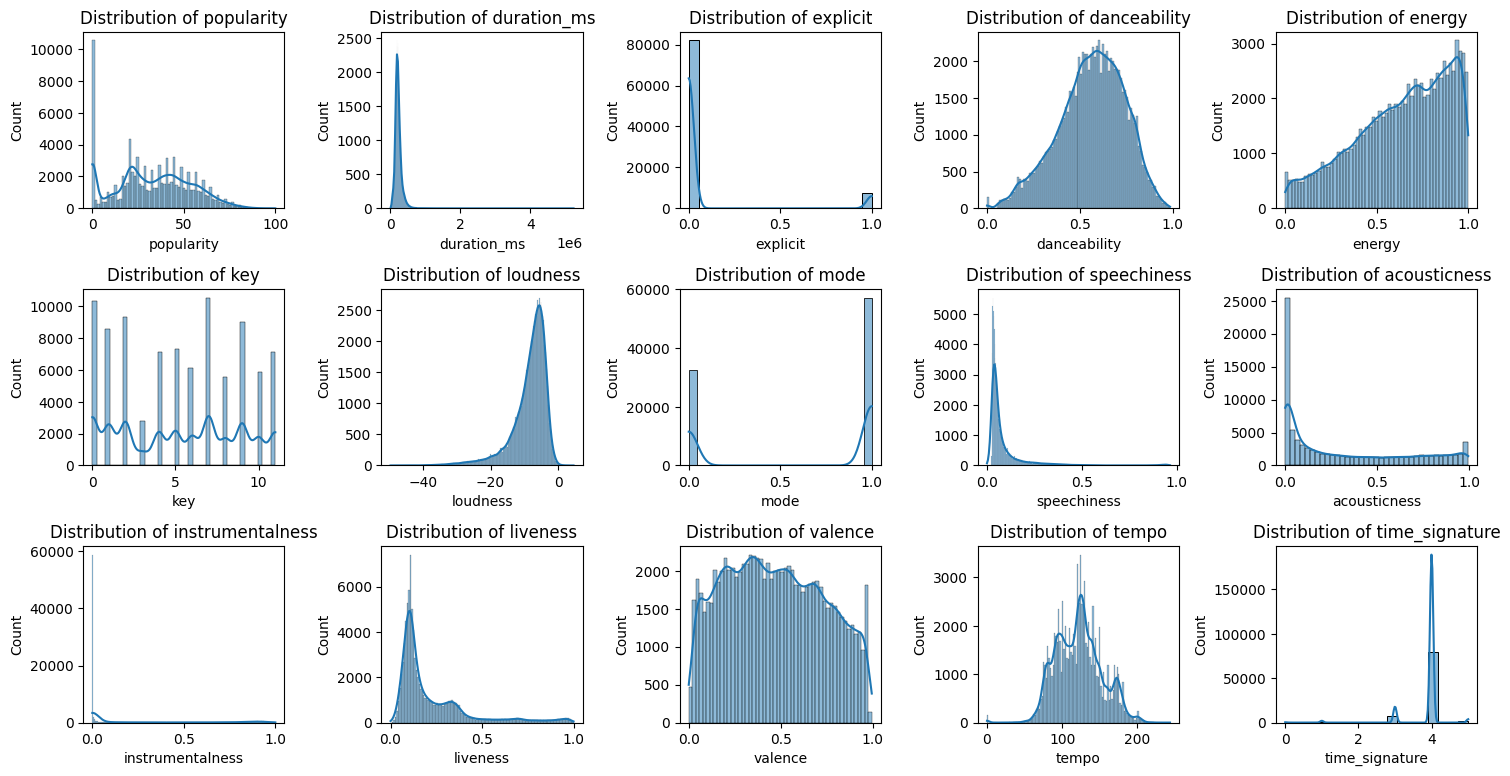

First 10 instances of 'track_genre':
0        j-pop
1     acoustic
2     acoustic
3     acoustic
4     acoustic
5    indie-pop
6     acoustic
7     acoustic
8     acoustic
9     acoustic
Name: track_genre, dtype: object

Value counts for 'track_genre':
track_genre
tango          1000
study           998
salsa           998
sleep           998
idm             996
               ... 
indie           361
alternative     317
reggae          310
latino          269
reggaeton       245
Name: count, Length: 114, dtype: int64


/var/folders/t3/h38q5w_d36ncdxty42rj79mr0000gn/T/ipykernel_4976/2533807060.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, fontsize=8)


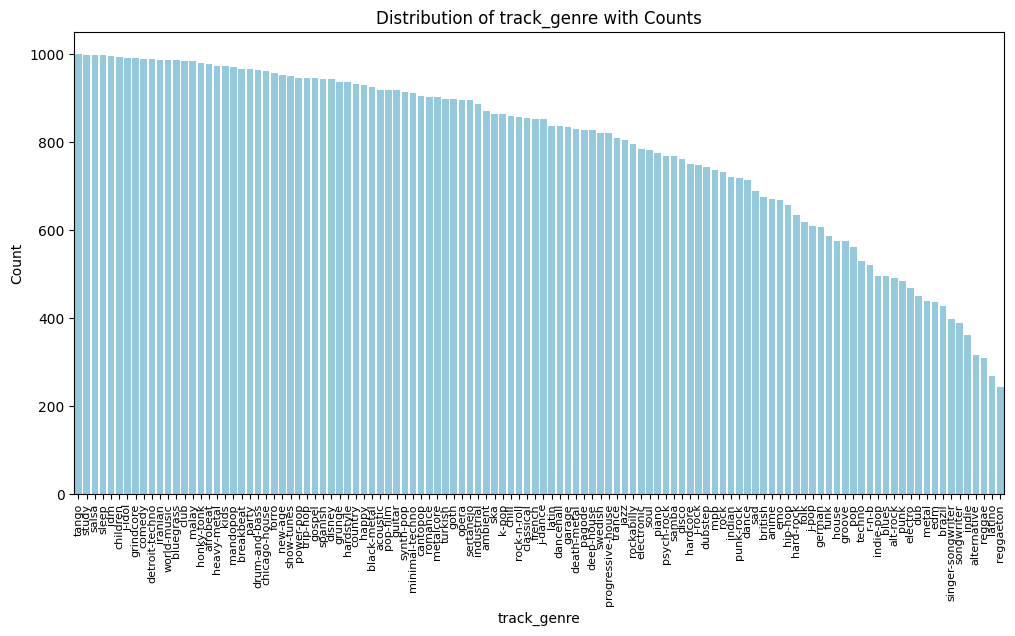

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def get_numeric_features_distribution(df):
    # Select numeric features
    numeric_features = df.select_dtypes(include=['float64', 'int64']).columns

    # Set up the matplotlib figure for feature distributions
    plt.figure(figsize=(15, 10))

    # Plot histograms for each numeric feature
    for i, feature in enumerate(numeric_features, 1):
        plt.subplot(4, 5, i)
        sns.histplot(df[feature], kde=True)
        plt.title(f'Distribution of {feature}')

    plt.tight_layout()
    plt.show()


def get_feature_distribution(df, target_column='track_genre'):
    # Display the first 10 instances of the target variable
    print(f"First 10 instances of '{target_column}':")
    print(df[target_column].head(10))

    # Display value counts for the target variable
    print(f"\nValue counts for '{target_column}':")
    print(df[target_column].value_counts())

    # Display the distribution of the target variable with counts on the y-axis
    value_counts = df[target_column].value_counts()

    plt.figure(figsize=(12, 6))
    barplot = sns.barplot(x=value_counts.index, y=value_counts.values, color='skyblue')
    plt.title(f'Distribution of {target_column} with Counts')
    plt.xlabel(target_column)
    plt.ylabel('Count')

    # Rotate x-labels vertically and set font size
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90, fontsize=8)

    plt.show()

get_numeric_features_distribution(df)
get_feature_distribution(df, target_column='track_genre')


# Data Understanding #

As __redundant__ and __irrelevant__ variables can decrease performance of the Naive Bayes, we will try to omit them. __Correlation matrix__ will help us to reveal redundant features (features with strong correlation)

Strongly correlated pairs of features and their correlation values:
energy and loudness: 0.7587736370436329


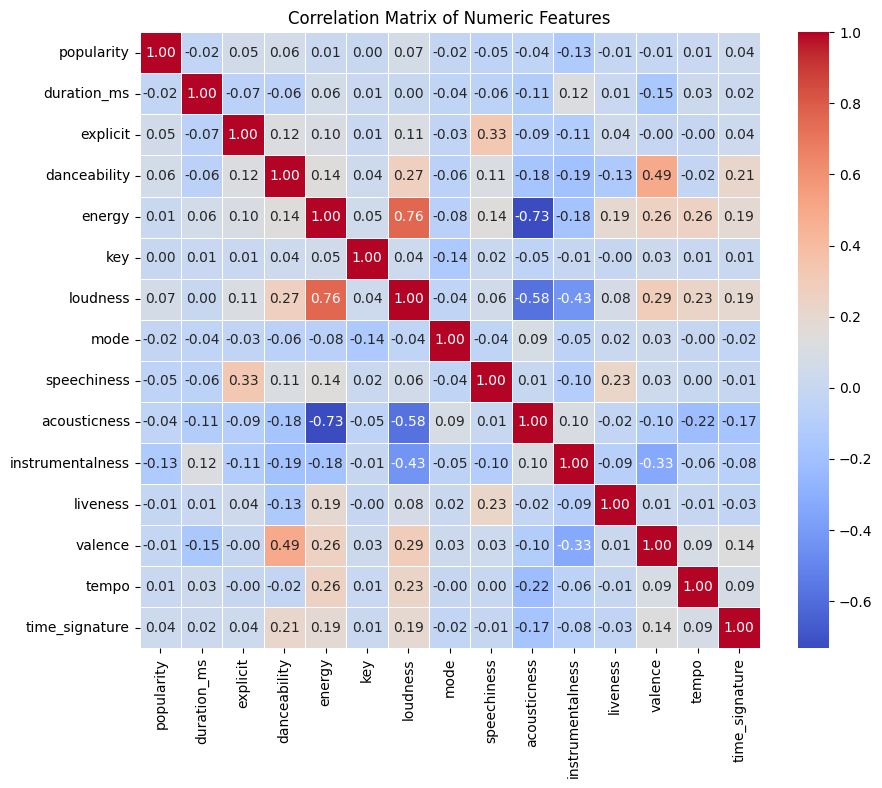

In [26]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your original DataFrame
numeric_features = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix among numeric features
correlation_matrix = numeric_features.corr()

# Set the upper triangle of the correlation matrix (including the diagonal) to NaN
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find strongly correlated pairs of features (using a threshold, e.g., 0.5)
strongly_correlated_pairs = []
for i in range(len(upper_triangle.columns)):
    for j in range(i + 1, len(upper_triangle.columns)):
        if upper_triangle.iloc[i, j] > 0.5:
            feature_i, feature_j = upper_triangle.columns[i], upper_triangle.columns[j]
            correlation_value = upper_triangle.iloc[i, j]
            strongly_correlated_pairs.append((feature_i, feature_j, correlation_value))

# Display strongly correlated pairs and their correlation values
print("Strongly correlated pairs of features and their correlation values:")
for pair in strongly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numeric Features')
plt.show()

# Data Preprocessing #


* From the strongly correlated pair of energy and loudness we will omit energy since it follows __normal distribution__ (main density function for Gaussian Naive Bayes) less than loudness feature. 

* __Drop__ irrelevant features for deriving the track genre like explicit feature (presence of the lyrics for the particular song) and etc.

* __Scale__ all remaining features via MinMaxScaler


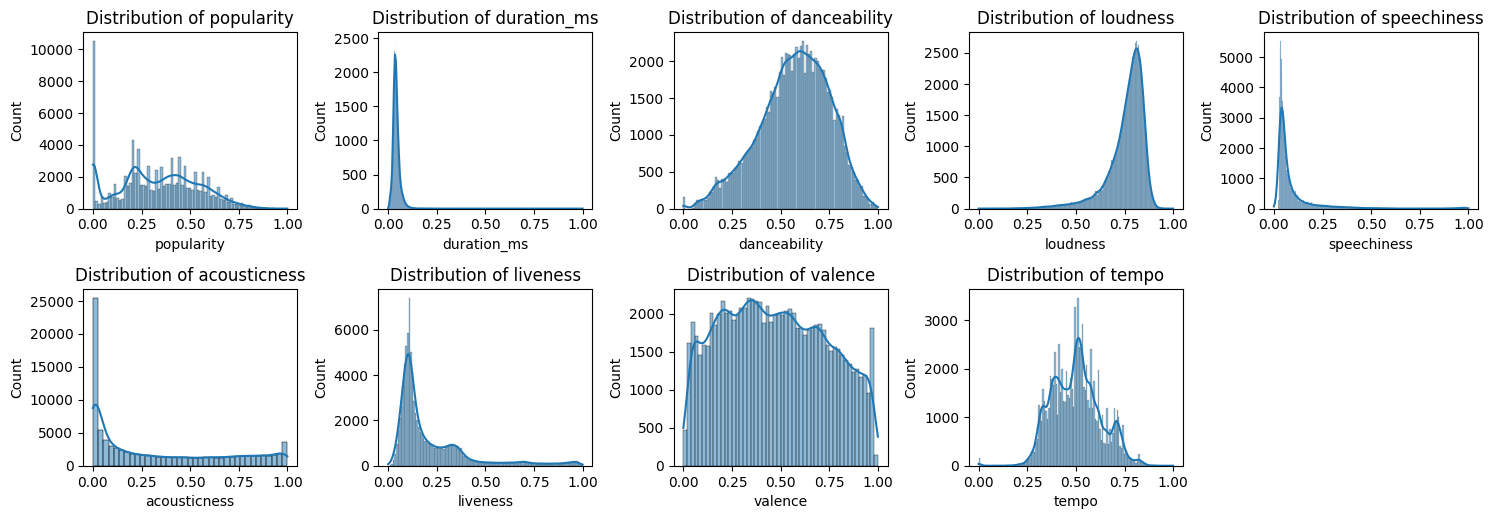

In [35]:
from sklearn.preprocessing import MinMaxScaler

songs_df = df.drop(columns = ["track_id", "artists", "album_name", "track_name", "explicit", "key", "energy", "time_signature", "mode", "instrumentalness", "track_genre"])
genres = df["track_genre"]

# Assuming songs_df contains only numeric features
numeric_features = songs_df.columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Scale the numeric features
songs_df[numeric_features] = scaler.fit_transform(songs_df[numeric_features])

# songs_df.head()
get_numeric_features_distribution(songs_df)


# Parameter tuning #

Via cross validation we will try to calculate the best portion of the largest variance of all features that is added to variances for calculation stability (__var_smoothing__)

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data into features (X) and target variable (y)
X = songs_df
y = df['track_genre']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gaussian Naive Bayes classifier
nb_classifier = GaussianNB()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=nb_classifier, param_grid=param_grid, scoring=make_scorer(f1_score, average='weighted'), cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'var_smoothing': 1e-07}


# Model Training #

In [39]:
# Train the classifier with the best hyperparameters
best_nb_classifier = GaussianNB(var_smoothing=best_params['var_smoothing'])
best_nb_classifier.fit(X_train, y_train)

# Make predictions on the test set
predictions = best_nb_classifier.predict(X_test)

# Model Evaluation #

In [40]:
# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, predictions)
f1_weighted = f1_score(y_test, predictions, average='weighted')

# Print the results
print("Gaussian Naive Bayes Classifier Performance:")

print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1_weighted}")

Gaussian Naive Bayes Classifier Performance:
Accuracy: 0.22537330064631156
F1-score: 0.18598322710352935
